# Split Learning and SplitGuard detection proposed in paper <SplitGuard: Detecting and Mitigating Training-Hijacking Attacks in Split Learning>

## Initialization and model defination

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'
import secretflow as sf
import matplotlib.pyplot as plt
sf.shutdown()
sf.init(['alice', 'bob'], address='local',num_cpus=5)
alice, bob = sf.PYU('alice'), sf.PYU('bob')
partys=[alice,bob]
import torch
from torch import nn as nn
from torch.nn import functional as F

from secretflow.ml.nn.utils import BaseModule
class ConvNetBase(BaseModule):
    """Small ConvNet basenet for MNIST."""

    def __init__(self):
        super(ConvNetBase, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=3,
                kernel_size=3,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(192, 64)

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

    def output_num(self):
        return 1


class ConvNetFuse(BaseModule):
    """Small ConvNet basenet for MNIST."""

    def __init__(self):
        super(ConvNetFuse, self).__init__()
        self.fc1 = nn.Linear(64 * 2, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = torch.cat(x, dim=1)
        x = x.view(-1, 128)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

2023-10-09 17:40:29,766	INFO worker.py:1538 -- Started a local Ray instance.
2023-10-09 17:40:54.248169: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-09 17:40:54.262854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-10-09 17:40:54.262894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Use label replace to compute the SG score(replace 7 batches out of 79 batches) 

In [2]:
import math
import os
import tempfile

import numpy as np
from torch import nn, optim
from torchmetrics import Accuracy, Precision, AUROC
from secretflow.device import reveal
from slmodelsg import SLModel_SG
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn.utils import TorchModel
from secretflow.security.privacy import DPStrategy
from secretflow.security.privacy.mechanism.torch import GaussianEmbeddingDP
from secretflow.security.privacy.mechanism.label_dp import LabelDP
from secretflow.utils.compressor import TopkSparse
_temp_dir = tempfile.mkdtemp()
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28, 1)
from secretflow.utils.simulation.data.ndarray import create_ndarray
from secretflow.data.ndarray import FedNdarray, PartitionWay
from secretflow.device.device.pyu import PYU
from typing import Dict, List, Tuple, Union
import random
from collections import namedtuple
from secretflow.utils.simulation.datasets import get_dataset

_Dataset = namedtuple('_Dataset', ['filename', 'url', 'sha256'])

_DATASETS = {
    'mnist': _Dataset(
        'mnist.npz',
        'https://secretflow-data.oss-accelerate.aliyuncs.com/datasets/mnist/mnist.npz',
        '731c5ac602752760c8e48fbffcf8c3b850d9dc2a2aedcf2cc48468fc17b673d1',
    )}

def load_mnist(
    parts: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    normalized_x: bool = True,
    categorical_y: bool = False,
    is_torch: bool = False,
) -> Tuple[Tuple[FedNdarray, FedNdarray], Tuple[FedNdarray, FedNdarray]]:
    filepath = get_dataset(_DATASETS['mnist'])
    with np.load(filepath) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
    # Set fake batches as paper.
    for i in range(8):
        for index in range(128*(i*10+1),128*(i*10+2)):
            y_test[index]=(y_test[index]+ random.randint(1,8)) % 10
    if normalized_x:
        x_train, x_test = x_train / 255, x_test / 255

    if categorical_y:
        from sklearn.preprocessing import OneHotEncoder

        encoder = OneHotEncoder(sparse=False)
        y_train = encoder.fit_transform(y_train.reshape(-1, 1))
        y_test = encoder.fit_transform(y_test.reshape(-1, 1))
    return (
        (
            create_ndarray(x_train, parts=parts, axis=0, is_torch=is_torch),
            create_ndarray(y_train, parts=parts, axis=0),
        ),
        (
            create_ndarray(x_test, parts=parts, axis=0, is_torch=is_torch),
            create_ndarray(y_test, parts=parts, axis=0),
        ),
    )

def create_dataset_builder(
    batch_size=32,
):
    def dataset_builder(x):
        import pandas as pd
        import torch
        import torch.utils.data as torch_data

        x = [t.values if isinstance(t, pd.DataFrame) else t for t in x]
        x_copy = [torch.tensor(t.copy()) for t in x]

        data_set = torch_data.TensorDataset(*x_copy)
        dataloader = torch_data.DataLoader(
            dataset=data_set,
            batch_size=batch_size,
        )
        return dataloader

    return dataset_builder


def torch_model_with_mnist(
    devices,
    base_model_dict,
    device_y,
    model_fuse,
    data,
    label,
    strategy='split_nn',
    backend='torch',
    **kwargs
):
    # kwargs parsing
    dp_strategy_dict = kwargs.get('dp_strategy_dict', None)
    compressor = kwargs.get('compressor', None)
    dataset_builder = kwargs.get('dataset_builder', None)

    base_local_steps = kwargs.get('base_local_steps', 1)
    fuse_local_steps = kwargs.get('fuse_local_steps', 1)
    bound_param = kwargs.get('bound_param', 0.0)

    loss_thres = kwargs.get('loss_thres', 0.01)
    split_steps = kwargs.get('split_steps', 1)
    max_fuse_local_steps = kwargs.get('max_fuse_local_steps', 10)

    party_shape = data.partition_shape()
    alice_length = party_shape[devices[0]][0]
    
    # Define model class using modified class SLModel_SG 
    sl_model = SLModel_SG(
        base_model_dict=base_model_dict,
        device_y=device_y,
        model_fuse=model_fuse,
        dp_strategy_dict=dp_strategy_dict,
        compressor=compressor,
        simulation=True,
        random_seed=1234,
        backend=backend,
        strategy=strategy,
        base_local_steps=base_local_steps,
        fuse_local_steps=fuse_local_steps,
        bound_param=bound_param,
        loss_thres=loss_thres,
        split_steps=split_steps,
        max_fuse_local_steps=max_fuse_local_steps,
    )
    # The fit() function is modified.
    history = sl_model.fit(
        data,
        label,
        validation_data=(data, label),
        epochs=2,
        batch_size=128,
        shuffle=False,
        random_seed=1234,
        dataset_builder=dataset_builder,
    )
    global_metric = sl_model.evaluate(
        data,
        label,
        batch_size=128,
        random_seed=1234,
        dataset_builder=dataset_builder,
    )

    # test history
    print(global_metric)
    print(history)
    assert math.isclose(
        global_metric['MulticlassAccuracy'],
        history['val_MulticlassAccuracy'][-1],
        rel_tol=0.01,
    )

    # assert global_metric['MulticlassAccuracy'] > 0.8
    result = sl_model.predict(data, batch_size=128, verbose=1)
    reveal_result = []
    for rt in result:
        reveal_result.extend(reveal(rt))
    assert len(reveal_result) == alice_length
    base_model_path = os.path.join(_temp_dir, "base_model")
    fuse_model_path = os.path.join(_temp_dir, "fuse_model")
    sl_model.save_model(
        base_model_path=base_model_path,
        fuse_model_path=fuse_model_path,
        is_test=True,
    )
    sl_model_load = SLModel_SG(
        base_model_dict=base_model_dict,
        device_y=device_y,
        model_fuse=model_fuse,
        dp_strategy_dict=dp_strategy_dict,
        compressor=compressor,
        simulation=True,
        random_seed=1234,
        backend=backend,
        strategy=strategy,
        base_local_steps=base_local_steps,
        fuse_local_steps=fuse_local_steps,
        bound_param=bound_param,
    )
    sl_model_load.load_model(
        base_model_path=base_model_path,
        fuse_model_path=fuse_model_path,
        is_test=True,
    )
    reload_metric = sl_model_load.evaluate(
        data,
        label,
        batch_size=128,
        random_seed=1234,
        dataset_builder=dataset_builder,
    )
    assert math.isclose(
        global_metric['MulticlassAccuracy'],
        reload_metric['MulticlassAccuracy'],
        rel_tol=0.01,
    )
    # Visualize results
    sl_model.plot_sgscore()

In [3]:
def test_torch_model(devices):
    alice = devices[0]
    bob = devices[1]
    num_samples = 10000
    (_, _), (mnist_data, mnist_label) = load_mnist(
        parts={
            alice: (0, num_samples),
            bob: (0, num_samples),
        },
        normalized_x=True,
        categorical_y=True,
        is_torch=True,
    )
    mnist_data = mnist_data.astype(np.float32)
    mnist_label = mnist_label.astype(np.float32)
    loss_fn = nn.CrossEntropyLoss
    optim_fn = optim_wrapper(optim.Adam, lr=1e-2)
    base_model = TorchModel(
        model_fn=ConvNetBase,
        loss_fn=loss_fn,
        optim_fn=optim_fn,
        metrics=[
            metric_wrapper(
                Accuracy, task="multiclass", num_classes=10, average='micro'
            ),
            metric_wrapper(
                Precision, task="multiclass", num_classes=10, average='micro'
            ),
            metric_wrapper(AUROC, task="multiclass", num_classes=10),
        ],
    )

    fuse_model = TorchModel(
        model_fn=ConvNetFuse,
        loss_fn=loss_fn,
        optim_fn=optim_fn,
        metrics=[
            metric_wrapper(
                Accuracy, task="multiclass", num_classes=10, average='micro'
            ),
            metric_wrapper(
                Precision, task="multiclass", num_classes=10, average='micro'
            ),
            metric_wrapper(AUROC, task="multiclass", num_classes=10),
        ],
    )
    base_model_dict = {
        alice: base_model,
        bob: base_model,
    }
    # Define DP operations
    gaussian_embedding_dp = GaussianEmbeddingDP(
        noise_multiplier=0.5,
        l2_norm_clip=1.0,
        batch_size=128,
        num_samples=num_samples,
        is_secure_generator=False,
    )
    dp_strategy_alice = DPStrategy(embedding_dp=gaussian_embedding_dp)
    label_dp = LabelDP(eps=64.0)
    dp_strategy_bob = DPStrategy(label_dp=label_dp)
    dp_strategy_dict = {
        alice: dp_strategy_alice,
        bob: dp_strategy_bob,
    }

    # test dataset builder
    print("test Dataset builder")
    dataset_buidler_dict = {
        alice: create_dataset_builder(
            batch_size=128,
        ),
        bob: create_dataset_builder(
            batch_size=128,
        ),
    }
    torch_model_with_mnist(
        devices=devices,
        base_model_dict=base_model_dict,
        device_y=bob,
        model_fuse=fuse_model,
        data=mnist_data,
        label=mnist_label,
        strategy='split_nn',
        backend="torch",
        dataset_builder=dataset_buidler_dict,
    )


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fe72adba760>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fe72adba790>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fe72adbaaf0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fe72adba970>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 128, 'epochs': 2, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fe72adba760>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fe72adba790>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedN

{'val_loss': array(0.38500783, dtype=float32), 'MulticlassAccuracy': tensor(0.8078), 'MulticlassPrecision': tensor(0.8078), 'MulticlassAUROC': tensor(0.9486)}
{'train_loss': [array(0.55221456, dtype=float32), array(0.4349817, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.6901), tensor(0.8080)], 'train_MulticlassPrecision': [tensor(0.6901), tensor(0.8080)], 'train_MulticlassAUROC': [tensor(0.9081), tensor(0.9331)], 'val_val_loss': [array(0.45470625, dtype=float32), array(0.38500783, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.7785), tensor(0.8078)], 'val_MulticlassPrecision': [tensor(0.7785), tensor(0.8078)], 'val_MulticlassAUROC': [tensor(0.9416), tensor(0.9486)]}


Predict Processing:: 100%|██████████| 79/79 [00:00<00:00, 149.14it/s]
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
(pid=52504) 2023-10-09 17:41:44.002724: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(pid=52504) 2023-10-09 17:41:44.002863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(pid=52504) 2023-10-09 17:41:44.002893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would li

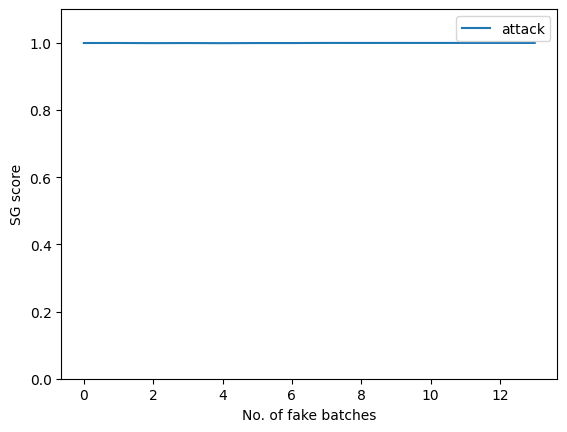

In [4]:
test_torch_model(partys)